In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Hyperparam

In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 1e-4
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels

trainx = 2.*trainx-1.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
np.min(trainx)

-1.0

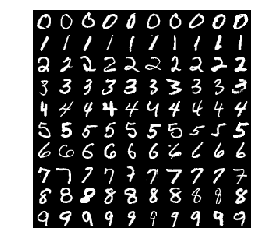

In [5]:
labeled =10
trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:100])
plt.show()

In [6]:
from mnist_model import generator,discriminator

## Build model

In [7]:
tf.reset_default_graph()

In [8]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])

train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params['batch_size'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params['batch_size'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
training_init_op = iterator.make_initializer(train_dataset)
validation_init_op = iterator.make_initializer(test_dataset)

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [9]:
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator net

samples = generator(noise,is_training_pl,reuse=False)
real_score = discriminator(data,is_training_pl,reuse=False)
fake_score = discriminator(samples,is_training_pl,reuse=True)


In [10]:
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

In [11]:
[print(v.name) for v in disc_vars]

discriminator/layer_1/conv/kernel:0
discriminator/layer_1/conv/bias:0
discriminator/layer_2/conv/kernel:0
discriminator/layer_2/conv/bias:0
discriminator/layer_2/batch_normalization/gamma:0
discriminator/layer_2/batch_normalization/beta:0
discriminator/layer_3/conv/kernel:0
discriminator/layer_3/conv/bias:0
discriminator/layer_3/batch_normalization/gamma:0
discriminator/layer_3/batch_normalization/beta:0
discriminator/layer_5/conv/kernel:0
discriminator/layer_5/conv/bias:0


[None, None, None, None, None, None, None, None, None, None, None, None]

In [12]:
[print(v.name) for v in gen_vars]

generator/layer_1/dconv/kernel:0
generator/layer_1/dconv/bias:0
generator/layer_1/batch_normalization/gamma:0
generator/layer_1/batch_normalization/beta:0
generator/layer_2/dconv/kernel:0
generator/layer_2/dconv/bias:0
generator/layer_2/batch_normalization/gamma:0
generator/layer_2/batch_normalization/beta:0
generator/layer_4/conv/kernel:0
generator/layer_4/conv/bias:0
generator/layer_4/batch_normalization/gamma:0
generator/layer_4/batch_normalization/beta:0
generator/layer_5/conv/kernel:0
generator/layer_5/conv/bias:0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [13]:
[print(v.name) for v in update_ops_gen]

generator/layer_1/batch_normalization/AssignMovingAvg:0
generator/layer_1/batch_normalization/AssignMovingAvg_1:0
generator/layer_2/batch_normalization/AssignMovingAvg:0
generator/layer_2/batch_normalization/AssignMovingAvg_1:0
generator/layer_4/batch_normalization/AssignMovingAvg:0
generator/layer_4/batch_normalization/AssignMovingAvg_1:0


[None, None, None, None, None, None]

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

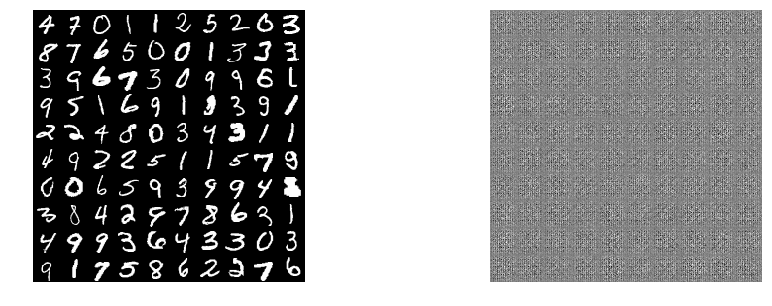

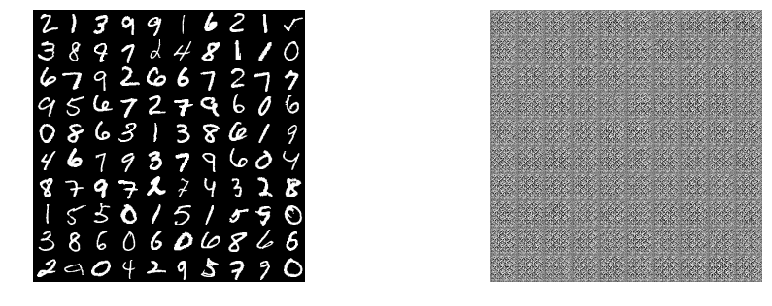

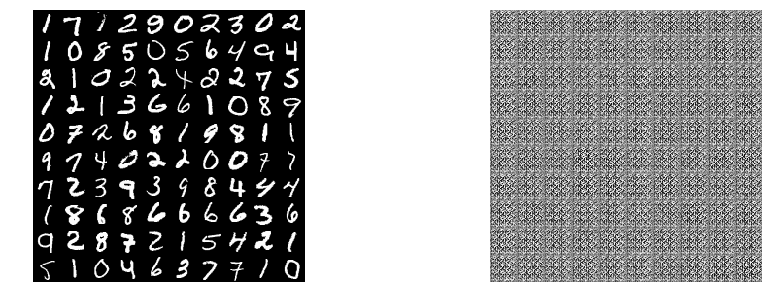

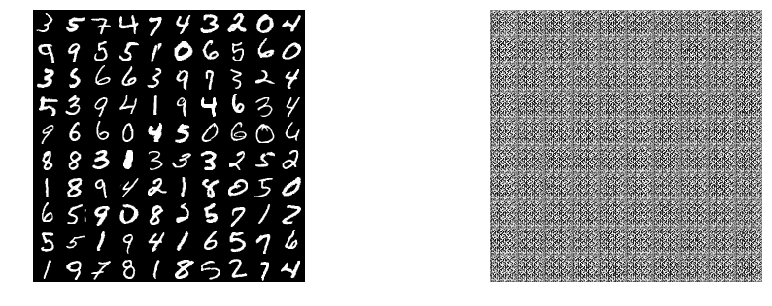

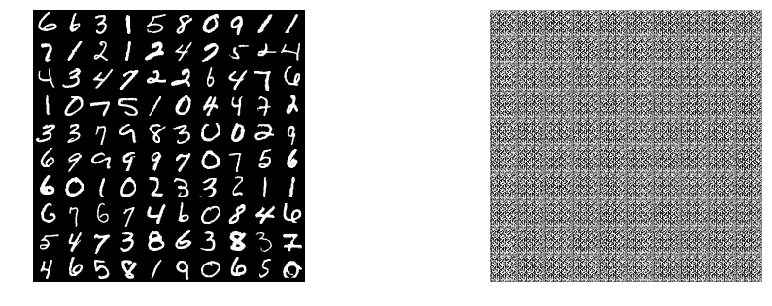

KeyboardInterrupt: 

In [15]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 200

for i in tqdm(range(20000)):
#     f, _= sess.run([[loss], train_op],{is_training_pl:True})
    f, _= sess.run([[loss_d], traind],{is_training_pl:True})
    f, _= sess.run([[loss_g], traing],{is_training_pl:True})

    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:False})
#         print('iter nr : ',gstep)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()

In [ ]:
perturb = tf.random_normal([params['batch_size'],params['z_dim']], mean=0, stddev=1)
perturb = tf.nn.l2_normalize(perturb, dim=[1])
noise_pert = noise + 5 * perturb

# samples = generator(noise,is_training_pl)
samples_perturb = generator(noise_pert, is_training_pl,output_dim=params['x_dim'], reuse=True)

samp_adv = samples + 1 * tf.nn.l2_normalize(samples-samples_perturb,dim=[1])


In [ ]:
xx,yy = sess.run([samples,samples_perturb],{is_training_pl:False})

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
show_digits(xx)
plt.subplot(122)
show_digits(yy)
plt.show()